In [77]:
import tensorflow as tf
import tensorflow_datasets as tfds
import math
import numpy as np
import os
import pandas as pd
import random
import shutil
import zipfile

from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

# Data Processing
## Import Data

In [3]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2021-06-12 02:40:48--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.36.52.129, 2600:1405:800:19c::e59, 2600:1405:800:1a6::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.36.52.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   204MB/s    in 3.9s    

2021-06-12 02:40:52 (201 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [26]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))
print()

12501
12501


In [89]:
base = '/tmp/cats-v-dogs'
train_dir = os.path.join(base, 'train')
validation_dir = os.path.join(base, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
try:
    shutil.rmtree(base)
    os.mkdir(base)
    os.mkdir(train_dir)
    os.mkdir(validation_dir)
    os.mkdir(train_cats_dir)
    os.mkdir(train_dogs_dir)
    os.mkdir(validation_cats_dir)
    os.mkdir(validation_dogs_dir)
except OSError:
    pass

In [90]:
def split_data(source, training, testing, split_size):
    image_list = os.listdir(source)
    len_list = len(image_list)
    shuffled_image_list = random.sample(image_list, len_list)
    train_size = int(len_list*split_size)
    for image in image_list[:train_size]:
        image_path = os.path.join(source, image)
        destination = os.path.join(training, image)
        if os.path.getsize(image_path) == 0:
            print(f"{image} is zero length, so ignoring")
        else:
            copyfile(image_path, destination)
    for image in image_list[train_size:]:
        image_path = os.path.join(source, image)
        destination = os.path.join(testing, image)
        if os.path.getsize(image_path) == 0:
            print(f"{image} is zero length, so ignoring")
        else:
            copyfile(image_path, destination)

In [91]:
split_size = 0.9
split_data('/tmp/PetImages/Cat/', train_cats_dir, validation_cats_dir, split_size)
split_data('/tmp/PetImages/Dog/', train_dogs_dir, validation_dogs_dir, split_size)

11250
666.jpg is zero length, so ignoring
11250
11702.jpg is zero length, so ignoring


In [92]:
print(len(os.listdir(train_cats_dir)))
print(len(os.listdir(train_dogs_dir)))
print(len(os.listdir(validation_cats_dir)))
print(len(os.listdir(validation_dogs_dir)))

11249
11249
1251
1251


## Visualize Images

In [95]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

nrows = 4
ncols = 4
pic_index = 0

(375, 500, 3)
(500, 251, 3)
(347, 500, 3)
(375, 500, 3)
(500, 444, 3)
(359, 480, 3)
(371, 500, 3)
(375, 500, 3)
(278, 370, 3)
(269, 500, 3)
(269, 179, 3)
(333, 500, 3)
(375, 500, 3)
(375, 500, 3)
(375, 500, 3)
(375, 500, 3)


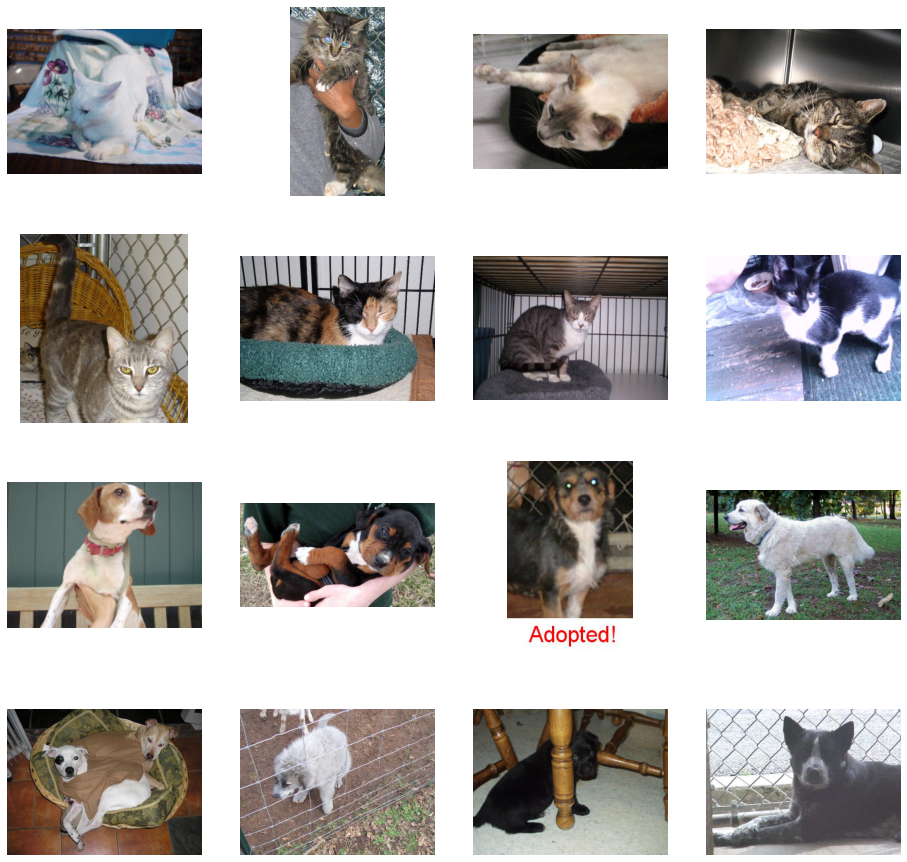

In [110]:
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

cat_fnames = os.listdir(train_cats_dir)
dog_fnames = os.listdir(train_dogs_dir)
cats = [os.path.join(train_cats_dir, fname) for fname in random.sample(cat_fnames, 8)]
dogs = [os.path.join(train_dogs_dir, fname) for fname in random.sample(dog_fnames, 8)]
for i, img_path in enumerate(cats+dogs):
    sp = plt.subplot(nrows, ncols, i+1)
    sp.axis('Off')
    img = mpimg.imread(img_path)
    print(img.shape)
    plt.imshow(img)
plt.show()

# Model
## CNN

In [106]:
model = keras.models.Sequential([
    keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    keras.layers.MaxPool2D(2, 2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPool2D(2, 2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPool2D(2, 2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 64)       

In [107]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-3),
              metrics=['acc'])

## ImageDataGenerator

In [134]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size = 64,
        class_mode='binary')
test_generator = train_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size = 64,
        class_mode='binary')

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


## Model Fitting

In [117]:
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=test_generator)

Epoch 1/15
1407/1407 [==============================] - 376s 267ms/step - loss: 0.5543 - acc: 0.7172 - val_loss: 0.4824 - val_acc: 0.7724
Epoch 2/15
1407/1407 [==============================] - 374s 266ms/step - loss: 0.5139 - acc: 0.7489 - val_loss: 0.6120 - val_acc: 0.7116
Epoch 3/15
1407/1407 [==============================] - 374s 266ms/step - loss: 0.4807 - acc: 0.7703 - val_loss: 0.4659 - val_acc: 0.7800
Epoch 4/15
 986/1407 [====================>.........] - ETA: 1:47 - loss: 0.4595 - acc: 0.7845

KeyboardInterrupt: 

## Tranfer Learning
### ResNet-50

In [136]:
import tensorflow_hub as hub
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

resnet = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(150, 150, 3)),
    hub.KerasLayer(resnet_url, trainable=False),
    keras.layers.Dense(1, activation="sigmoid")
])
# resnet.add(Resizing(224, 224, input_shape=INP_SHAPE))
resnet.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_5 (KerasLayer)   (None, 2048)              23564800  
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 2049      
Total params: 23,566,849
Trainable params: 2,049
Non-trainable params: 23,564,800
_________________________________________________________________


In [132]:
resnet.compile(optimizer="rmsprop",
               loss="binary_crossentropy",
               metrics = ["acc"])

In [135]:
resnet_history = resnet.fit(train_generator,
                            epochs=15,
                            validation_data=test_generator)

Epoch 1/15
142/352 [===========>..................] - ETA: 9:01 - loss: 0.0975 - acc: 0.9636

KeyboardInterrupt: 